In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [78]:
cwd = os.getcwd()
test_images_dir = os.path.join(cwd, "data/test_images")

img_h, img_w = 540, 960

In [86]:
def plot_images(images):
    fig, axes = plt.subplots(3, 2, figsize=(20, 18))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_yticks([])
        ax.set_xticks([])

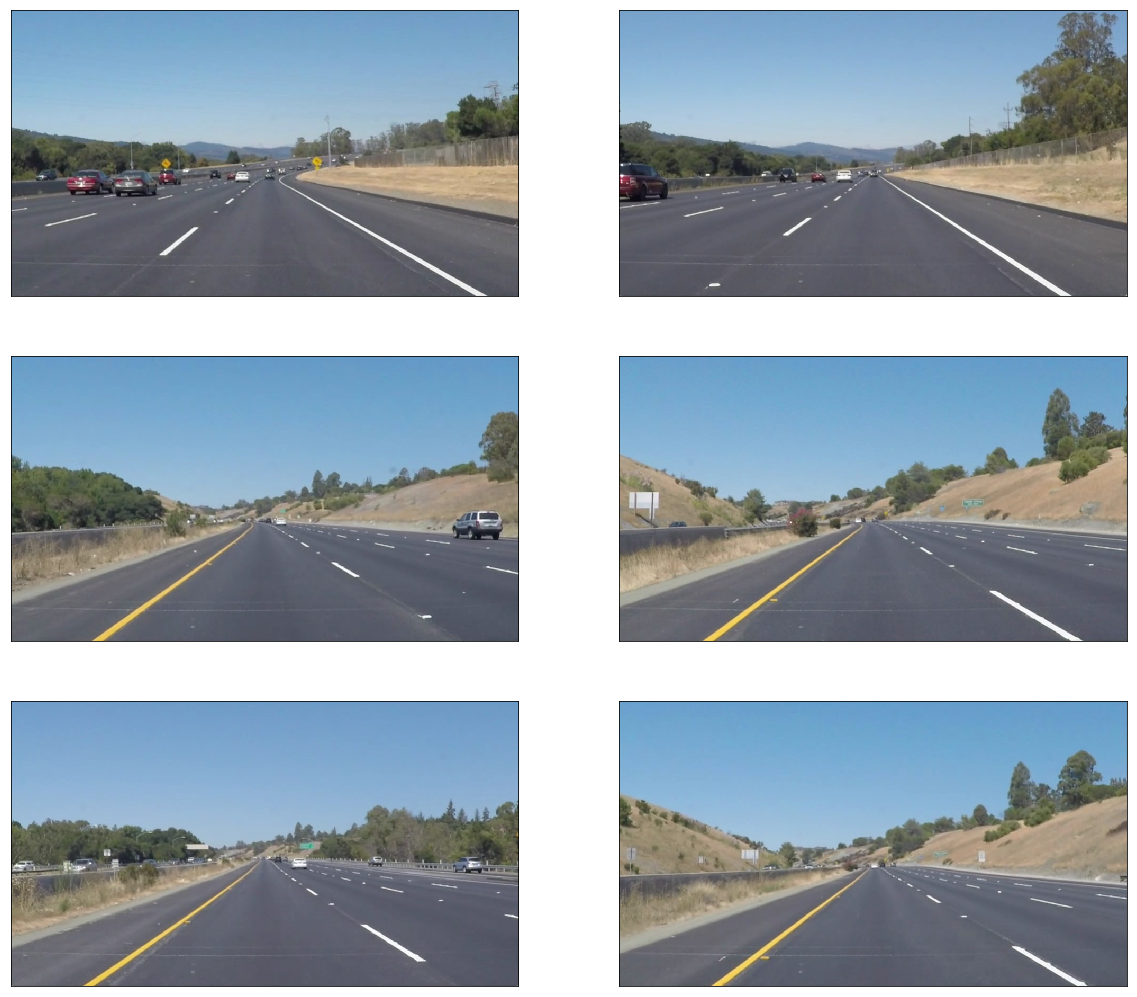

In [87]:
test_images = [cv2.cvtColor(cv2.imread(os.path.join(test_images_dir, img)), cv2.COLOR_BGR2RGB) for img in os.listdir(test_images_dir)]
plot_images(test_images)

In [149]:
test_images[0].shape

(540, 960, 3)

In [154]:
class Line:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        
        self.slope = self.line_slope()
        self.intercept = self.line_intercept()
        self.is_slope_positive = True if self.slope > 0 else False
        
    def line_slope(self):
        m = (self.y2-self.y1) / (self.x2-self.x1 + np.finfo(float).eps)
        return m
        
    def line_intercept(self):
        b = self.y1 - (self.slope*self.x1)
        return b
    
    def get_line_coordinates(self):
        return np.array([self.x1, self.y1, self.x2, self.y2])
    def set_line_coordinates(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2


def make_object(lines):
    detected_lines = []
    for line in lines:
        l = Line(line[0][0], line[0][1], line[0][2], line[0][3])
        if 0.5 <= np.abs(l.slope) <= 2:
            detected_lines.append(l)
    return detected_lines

def compute_pos_neg_lines(detected_lines):
    positive_lines, negative_lines = [], []
    for line in detected_lines:
        if line.is_slope_positive:
            positive_lines.append(line)
        else:
            negative_lines.append(line)
    return positive_lines, negative_lines

def compute_left_lane(negative_lines):
    negative_intercept = np.median([line.intercept for line in negative_lines]).astype(int)
    negative_slope = np.median([line.slope for line in negative_lines])
    x1, y1 = 0, negative_intercept
    x2, y2 = np.round(-negative_intercept/ negative_slope).astype(int), 0
    left_lane = Line(x1, y1, x2, y2)
    return left_lane

def compute_right_lane(positive_lines):
    positive_intercept = np.median([line.intercept for line in positive_lines]).astype(int)
    positive_slope = np.median([line.slope for line in positive_lines])
    x1, y1 = 0, positive_intercept
    x2, y2 = np.round((img_h - positive_intercept)/positive_slope).astype(int), img_h
    right_lane = Line(x1, y1, x2, y2)
    return right_lane
    
def compute_lanes(detected_lines):
    positive_lines, negative_lines = compute_pos_neg_lines(detected_lines)
    left_lane = compute_left_lane(negative_lines)
    right_lane = compute_right_lane(positive_lines)
    return left_lane, right_lane

def detect_lanes(img):
    img = cv2.resize(img, (img_w, img_h))
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    img_blur = cv2.GaussianBlur(img_gray, (15, 15), 0)

    img_edge = cv2.Canny(img_blur, threshold1=50, threshold2=100)
    
    lines = cv2.HoughLinesP(img_edge, rho=1, theta=np.pi/180, threshold=1, lines=np.array([]), minLineLength=15,maxLineGap=5)
    
    detected_lines = make_object(lines)
    left_lane, right_lane = compute_lanes(detected_lines)
    return left_lane, right_lane

In [156]:
left, right = detect_lanes(test_images[0])

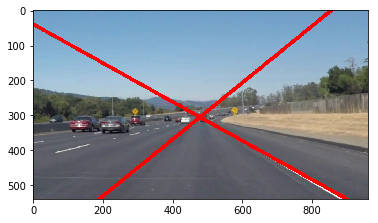

In [158]:
x1, y1, x2, y2 = left.get_line_coordinates()
cv2.line(test_images[0], (x1, y1), (x2, y2), color=[255, 0, 0], thickness=10)

x1, y1, x2, y2 = right.get_line_coordinates()
cv2.line(test_images[0], (x1, y1), (x2, y2), color=[255, 0, 0], thickness=10)

plt.imshow(test_images[0])